In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints
import gpmaniflow
from gpmaniflow.models.GPR import GPR

import gpmaniflow.samplers
from gpmaniflow.samplers import initialize_sampler
from gpmaniflow.curves import BezierCurve

In [2]:
pX = np.reshape(np.random.uniform(-2, 2, 200*2), [200, 2])
X = np.random.uniform(-3, 3, 200*2)[:, None]
X = np.reshape(X, [200, 2])
Y = 2 * X[:,0] ** 2 + 1 * X[:,1] + np.random.randn(200) * 0.1
Y = np.reshape(Y, [200,1])

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

In [3]:
kernel = gpflow.kernels.SquaredExponential()

model = GPR((X,Y), kernel)

training_loss = model.training_loss_closure(compile=True)
optimizer = tf.keras.optimizers.Adam(0.05)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
elbo_hist = []
for step in range(3000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

LML = model.log_marginal_likelihood()

Step: 0, Mini batch elbo: -839.5722508537931
Step: 50, Mini batch elbo: -504.2165255542822
Step: 100, Mini batch elbo: -333.6038515753934
Step: 150, Mini batch elbo: -200.15406093244064
Step: 200, Mini batch elbo: -158.998440315249
Step: 250, Mini batch elbo: -134.47211465167857
Step: 300, Mini batch elbo: -117.24323635856331
Step: 350, Mini batch elbo: -104.14200243438091
Step: 400, Mini batch elbo: -93.67811315296524
Step: 450, Mini batch elbo: -85.0337445076052
Step: 500, Mini batch elbo: -77.71342430361494
Step: 550, Mini batch elbo: -71.3953254654225
Step: 600, Mini batch elbo: -65.85926074675405
Step: 650, Mini batch elbo: -60.9483740013207
Step: 700, Mini batch elbo: -56.54724936527475
Step: 750, Mini batch elbo: -52.56867780767277
Step: 800, Mini batch elbo: -48.94528394648597
Step: 850, Mini batch elbo: -45.62402420036574
Step: 900, Mini batch elbo: -42.56245474507432
Step: 950, Mini batch elbo: -39.72613015824885
Step: 1000, Mini batch elbo: -37.08674699726595
Step: 1050, Min

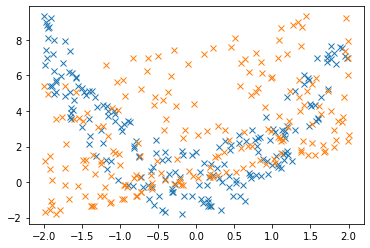

In [4]:
pmu, pvar = model.predict_f(pX)

plt.plot(pX, pmu, 'x')

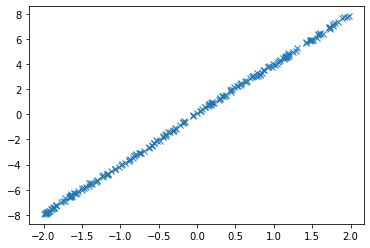

In [5]:
dmu, dvar = model.predict_df(pX)
plt.plot(pX[:,0], dmu[:,:,0], "x")

In [7]:
model.MatheronSampler = initialize_sampler(from_df = True, num_samples = 10)

I'm here


In [8]:
J = model.MatheronSampler(pX)
J.shape

TensorShape([10, 200, 2, 1])

In [ ]:
plt.plot(pX[:,0], J[0,:,0,0], 'x')